# Import all the module

In [33]:
from ipywidgets import interact
from MPC2_phy_proj import *

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the constrain condition

## total_dist(...)

This funciton will caluculate the total distance between all the molecular pair, (mimic nC2)

In [34]:
def total_dist(ri):
    '''
    calculate the total distance between each pair of atoms
    '''
    tot_value=0 #initialise the total potential energy
    chargeadded=[] #list of indices of charges already added
    for loop in range(len(ri)): #loop over each charge in turn
        #....incomplete code below which you can use as a starting point
        for j in chargeadded: #loop over charges already added (bringing charge loop towards charge j)            
            tot_value_ij=dist(ri[j],ri[loop])
            #print('Adding PE %.2e [units] of bringing charge %d towards charge %d' % (Uij,loop,j))
            tot_value=tot_value+tot_value_ij
        chargeadded.append(loop) #add the index of the added charge to the list
    return tot_value 

## constrain01(...,...)

The function defines there is a miminum distance between each O-O pairs, usuall consider the hydrogen bond (approxi.2.4A~2.6A)

In [35]:
def constrain01(xyz_coord,threshold):
    chargeadded=[] #list of indices of charges already added
    for loop in range(len(xyz_coord)): #loop over each charge in turn
        for j in chargeadded: #loop over charges already added (bringing charge loop towards charge j)            
            tot_value_ij=dist(xyz_coord[j],xyz_coord[loop])
            if tot_value_ij<threshold:
                return True
        chargeadded.append(loop)

# Generate the data set under constrain01(...,...)

The code cell bellow will generate the n --> range(n) coord. sets. and calculate all the successfully genetated sets under constrain01(...,...). It will also plot the lowest E_energy interactive diagram of the cardition cooridations of that atoms set.

__TWO IMPORTANT PARAMETER:__

__'for i in range(1000):'__: this n in 'range(n)' will decide how many coords sets will be generated.


__'O_O_mini_dist = 0.24 #unit in nm'__: FOr example, 0.24 here means the minimum distance beteween two OXYGEN atoms, usually regard to the hydrgen bond length. Unit in nm!

The lowest E_energy - potl_E_sum: -8.040840721498911e-18 J


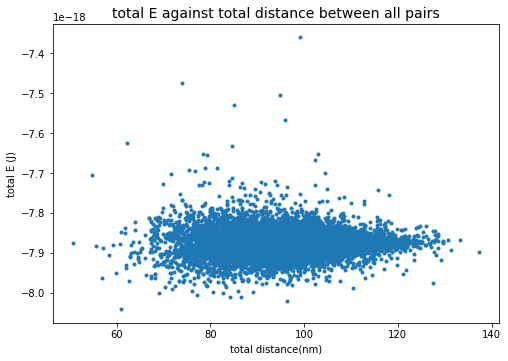

In [36]:
ditance_bw_all = []
total_E_all = []

datasets = []
#-------IMPORTANT-------BELOW-------range(1000)-------
for i in range(10000):
    # generate a set of coord.
    xa=np.random.rand(6)
    ya=np.random.rand(6)
    za=np.random.rand(6)
    thetar=np.random.rand(6)*np.pi*2 
    phir=np.random.rand(6)*np.pi*2 
    moltypes =[1,1,1,1,1,1] 
    xyza = np.stack((np.array(xa), np.array(ya),np.array(za)), axis=-1)
   
    #-------IMPORTANT-------BELOW-------O_O_mini_dist-------
    O_O_mini_dist = 0.22 #unit in nm.
    
    while constrain01(xyza,O_O_mini_dist): # test the genrated coord. set, if dist bw O-O < O_O_mini_dist, regenate the coord. sets
        #inside the loop, generate another set
        xa=np.random.rand(6)
        ya=np.random.rand(6)
        za=np.random.rand(6)
        thetar=np.random.rand(6)*np.pi*2 
        phir=np.random.rand(6)*np.pi*2 
        xyza = np.stack((np.array(xa), np.array(ya),np.array(za)), axis=-1)
        
        if constrain01(xyza,O_O_mini_dist):# test if the set is still:dist bw O-O < O_O_mini_dist
            continue# go to the beginning and re-genrate
        else:# find the dist bw O-O >= 0.266
            #calcuate the rall and qall            
            break# end the loop, this coord. set is generated successfully.

    # then, use this generated coord, save the data
    rall,qall = allatomposns(moltypes,xa,ya,za,phir,thetar)
    datasets.append([moltypes,xa,ya,za,phir,thetar])# all the succeed coord. set is saved here
     
    #calculate the total distance
    ditance_bw_all.append(total_dist(rall))
    #calculate the total E_energy
    rall = np.array(rall)*1e-9
    potl_E_sum = potl_energy_sum(rall,qall)
    total_E_all.append(potl_E_sum)# all the total E_energy of the succeed coord. set are saved here

#------the coord. set finishing generating------
#for all the successfully generated coord. sets, find the lowest one
total_E_all = np.array(total_E_all)
datasets = np.array(datasets)
lowest_index = np.argmin(total_E_all)

# calculate the lowest energy 
rall,qall = allatomposns(datasets[lowest_index][0],datasets[lowest_index][1],datasets[lowest_index][2],\
                         datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
rall = np.array(rall)*1e-9
potl_E_sum = potl_energy_sum(rall,qall)
print('The lowest E_energy - potl_E_sum:',potl_E_sum, 'J')
    

#-------plot------Total E against total distance-------
#plot all the possible coord.
plt.figure(figsize=(8,5.5)) 
plt.title('total E against total distance between all pairs',fontsize=14)
plt.plot(ditance_bw_all, total_E_all, marker='.',linestyle = '')

plt.xlabel('total distance(nm)')
plt.ylabel('total E (J)')
plt.show();

# Interactive：Version 1 （rcmd）

In [37]:
#split OXYGEN atoms in red, HYDROGEN atoms in blue
xall=[]
yall=[]
zall=[]
for i in range(int(len(rall))):
    xall.append(float(rall[i][0])*1e9)
    yall.append(float(rall[i][1])*1e9)
    zall.append(float(rall[i][2])*1e9)
#print('xall:',xall)
print('potl_E_sum:',potl_E_sum, 'J')

#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
fig = make_subplots()
O_atoms = go.Scatter3d(x=xall[::3], y=yall[::3], z=zall[::3],mode='markers',marker = {'color' : 'red'})
H_atoms01 = go.Scatter3d(x=xall[1::3], y=yall[1::3], z=zall[1::3],mode='markers',marker = {'color' : 'blue'})
H_atoms02 = go.Scatter3d(x=xall[2::3], y=yall[2::3], z=zall[2::3],mode='markers',marker = {'color' : 'blue'})

fig.add_trace(O_atoms)
fig.add_trace(H_atoms01)
fig.add_trace(H_atoms02)

fig.show()

potl_E_sum: -8.040840721498911e-18 J


# Interactive Version 2

In [26]:
#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
print('potl_E_sum:',potl_E_sum, 'J')

@interact
def make_plot_2(elevpara=(-27,90,3),azimpara=(-117,0,3)):
    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],\
                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_zlabel('z (nm)')
    ax1.set_title('molecule positions')
    ax1.set_aspect('auto')
    ax1.view_init(elev=elevpara, azim=azimpara) #adjust 'camera angle' with this command if desired - angles are in degrees
    f1.show();

potl_E_sum: -8.000540625034724e-18 J


interactive(children=(IntSlider(value=30, description='elevpara', max=90, min=-27, step=3), IntSlider(value=-6…